# EEG tutorial ERP

**Learning goals**
- Get familiar with the MNE toolbox for EEG analysis;
- Get familiar with sklearn for EEG decoding;
- Understand ERPs and their spatial and temporal components; 
- Understand temporal, spatial, and spatio-temporal decoding;
- Understand significance testing using the permutation test.

**Summary**

This notebook shows the basics of ERP analysis and classification in order to get familiar with commonly used toolboxes like MNE and sklearn. This notebook uses real EEG data shared on Zenodo. This notebook goes through several of the basic steps that are involved in an ERP-pipeline, including reading the data, preprocessing of the data, feature extraction, classification, model evaluation using cross-validation, and statistics using a permutation test. 

The notebook is organised as follows:
1. Downloading and setting up EEG data
2. Loading and preprocessing ERP data
3. Basic ERP plots
4. Classification in the spatial domain for different time intervals
5. Classification in the temporal domain for different channels
6. Classification in the spatio-temporal domain
7. Permutation testing


In [1]:
import glob
import os
import warnings
import yaml

from matplotlib import pyplot as plt
import mne
import numpy as np
from sklearn.model_selection import cross_val_score
from toeplitzlda.classification import ToeplitzLDA

mne.set_log_level('WARNING')
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


## Step 1: Downloading and setting up EEG data
The dataset contains data of three subjects. For each subject, data of a single session is available. Within a session, a resting state recording with eyes open and eyes closed has been performed at the beginning and the end, which you can ignore. In the main part of the session, an auditory oddball paradigm was executed. For two different stimulus onset asynchrony (SOA) values, a fast and a slow condition, 80 trials of oddball ERP data were collected. Within a trial, you should find 90 stimuli (75 low-pitched non-targets and 15 high-pitched targets). Please note, that the actual SOA values vary between subjects.

In addition to EEG channels, a number of other non-EEG channels have been recorded.

1. Retrieve the data from [Zenodo](https://zenodo.org/record/4066633) and store it at a convenient location locally;
1. In the code snippet below, set the `CONFIG_FILE_PATH` to point the folder where the `config.yaml` file is located;
1. Open the `config.yaml` file in a text editor, and change the `data_path` on line 1 to point to the path where you downloaded the data.

In [2]:
# Adjust this CONFIG_FILE_PATH to point to the config.yaml file
CONFIG_FILE_PATH = os.path.join(os.getcwd(), 'config.yaml')

# Load the file
conf = yaml.load(open(CONFIG_FILE_PATH, 'r'), Loader=yaml.FullLoader)

## Step 2: Loading and processing ERP data

The code below performs a standard ERP preprocessing, including:
- A spectral notch filter to remove line noise
- A spectral bandpass filter to isolate the relevant frequency band for ERP analysis
- Epoching to slice the continuous data to windows around individual stimulus presentations
- Outlier rejection of epochs based on maximum amplitude in an epoch
- Baselining to apply baseline correction for each epoch
- Downsampling to reduce the amount of data along the temporal axis 


In [3]:
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
raw_stim_ids = {"Stimulus/S  1": 1, "Stimulus/S 21": 2}
class_ids = {"Target": 2, "Non-target": 1}

notch = 50.0  # line noise (Hz)
l_freq = 1.5  # high pass cutoff (Hz)
h_freq = 16.0  # low pass cutoff (Hz)
tmin = -0.2  # start of an epoch (s)
tmax = 0.5  # end of an epoch (s)
reject = dict()  # reject = dict(eeg=60 * 1e-6)  # max amplitude rejection threshold (muV)
baseline_ival = None  # (-.2, 0)  # interval for baselining (s, s)
decimate = 10  # decimation factor for downsampling

all_data = dict()
for session in conf['auditory_oddball']['session_list']:
    for condition in conf['auditory_oddball']['condition_list']:
        
        # Find files
        search_path = os.path.join(conf['data_path'], session, f"*{condition}.vhdr")
        eeg_filepaths = sorted(glob.glob(search_path))

        if len(eeg_filepaths) == 0:
            print(f"No files found for session {session} and condition {condition}!")
            break

        epo_arr = []
        for eeg_filepath in eeg_filepaths:
            print(f'Loading file {os.path.basename(eeg_filepath)}')

            # Read raw continuous data
            eeg = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels)

            # Set electrode positions
            eeg.set_montage('standard_1020').load_data()

            # Select EEG channels only
            eeg.pick_types(eeg=True)

            # Spectral notch filter
            eeg.notch_filter(freqs=np.arange(notch, eeg.info['sfreq'] / 2, notch))

            # Spectral filter
            eeg.filter(l_freq=l_freq, h_freq=h_freq, method='iir')

            # Slice to epochs
            # Note, includes baselining, downsample, and outlier rejection
            events = mne.events_from_annotations(eeg, event_id=raw_stim_ids)[0]
            epo = mne.Epochs(eeg, events=events, event_id=class_ids, tmin=tmin, tmax=tmax, 
                             baseline=baseline_ival, decim=decimate, reject=reject, proj=False, preload=True)

            # Add epochs to dataset
            epo_arr.append(epo)
        
        # Add to data stack
        if session not in all_data:
            all_data[session] = dict()
        if condition not in all_data[session]:
            all_data[session][condition] = mne.concatenate_epochs(epo_arr)

print("Done!")

Loading file Oddball_Run_2_Trial_016_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_017_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_018_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_019_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_020_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_036_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_037_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_038_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_039_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_040_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_056_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_057_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_058_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_059_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_060_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_076_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Trial_077_SOA_0.208_fast.vhdr
Loading file Oddball_Run_2_Tria

In [4]:
# Some useful properties of a dataset

print("Sample frequency raw:", eeg.info["sfreq"])
print("Sample frequency epo:", epo.info["sfreq"])

n_channels = len(eeg.info["chs"])
print("Channel count:", n_channels)
print("Channels: ", eeg.ch_names)

print("Markers: ", epo.event_id)

print()
print(eeg.info)

print()
print(epo.info)


Sample frequency raw: 1000.0
Sample frequency epo: 100.0
Channel count: 31
Channels:  ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'F9', 'F10', 'P9', 'P10']
Markers:  {'Target': 2, 'Non-target': 1}

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 31 EEG
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 1.5 Hz
 lowpass: 16.0 Hz
 meas_date: 1924-01-01 00:00:00 UTC
 nchan: 31
 projs: []
 sfreq: 1000.0 Hz
>

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 31 EEG
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 1.5 Hz
 lowpass: 16.0 Hz
 meas_date: 1924-01-01 00:00:00 UTC
 nchan: 31
 projs: []
 sfreq: 100.0 Hz
>


## Step 3: Basic ERP plots

Event-related potentials are typically computed by averaging all epochs in the dataset that belong to the same condition. As a basic analysis, we visualize the ERPs over time, with time after stimulus on the x-axis. Additionally, we define certain time points at which we want to plot the signal topography over the whole scalp. 

**Note:** we are only averaging target ERPs that belong to a specific condition (fast or slow), and do so for each participant separately (1, 2, and 3). 


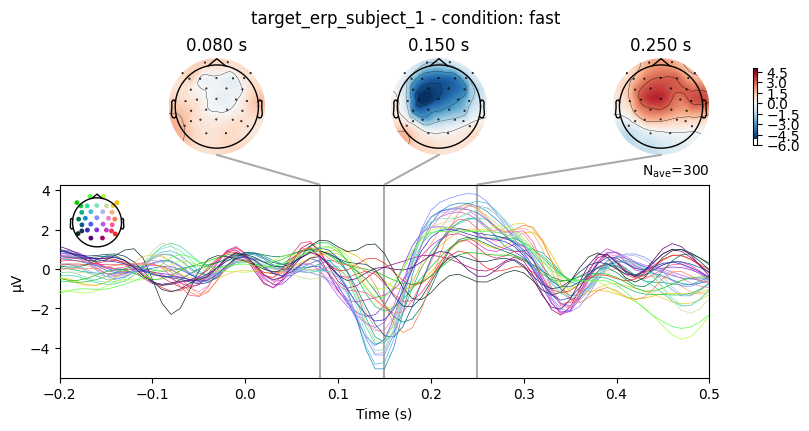

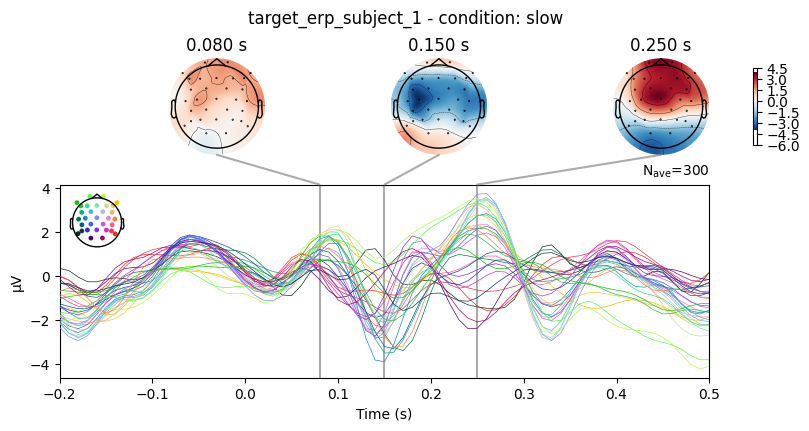

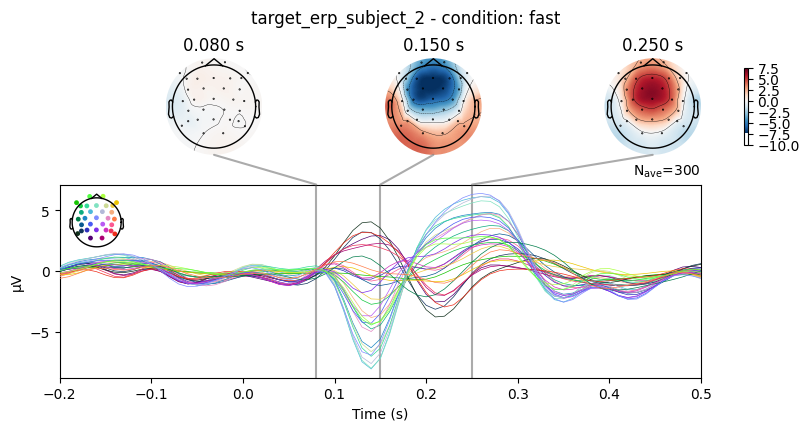

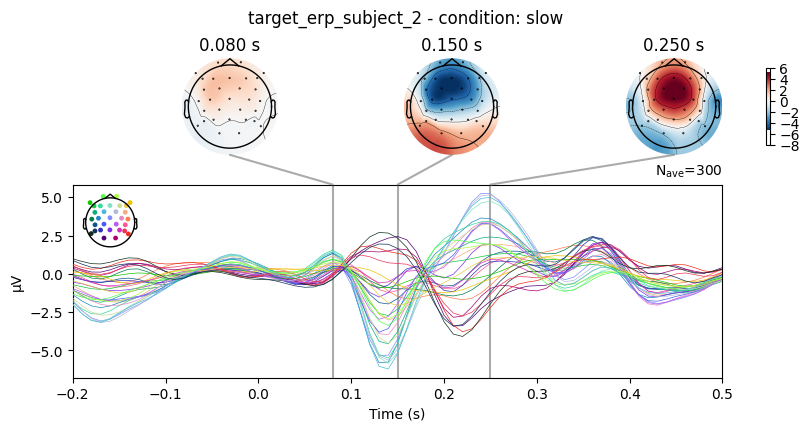

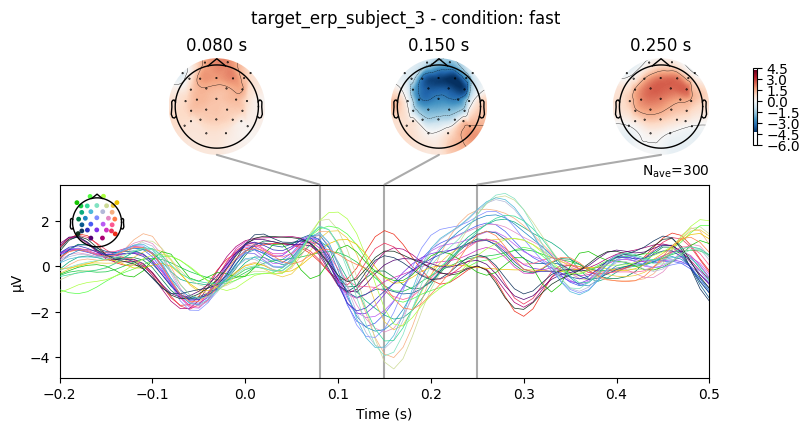

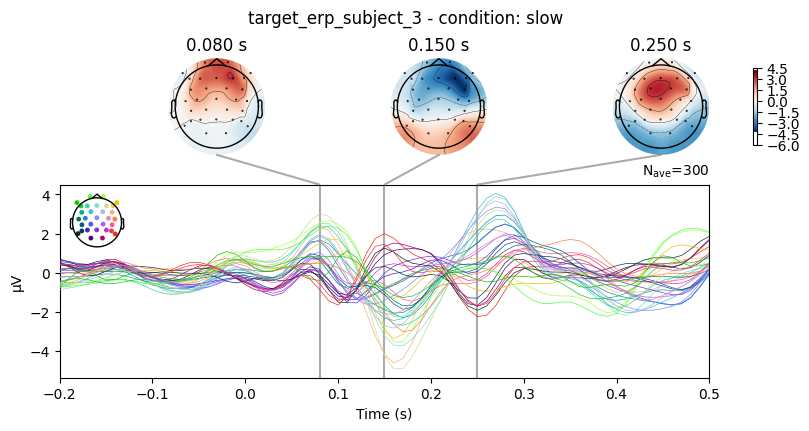

In [5]:
scalp_times = (0.080, 0.150, 0.250)  # times for a topoplot (s)

for session in conf['auditory_oddball']['session_list']:
    for condition in conf['auditory_oddball']['condition_list']:
        epo = all_data[session][condition]
        
        # Compute ERP
        t_evoked = epo['Target'].average()
        
        # Plot ERP
        t_evoked.plot_joint(title=f'target_{session} - condition: {condition}', times=scalp_times)     
        

## Step 4: Classification in the spatial domain for different time intervals

As a first step, we want to classify the target vs. non-target signals. Remember that our data has the following dimensionality: $X_i \in \mathbb{R}^{N_c \times N_t}$ with $X_i$ being the $i$th epoch, $N_c$ being the number of channels and $N_t$ being the number of time samples available in the $i$-th epoch. In the next step, we will only use spatial information for classification, that is, we choose an arbitrary time-point such as 200ms after the stimulus, and use the 31-dimensional feature vector ($N_c = 31$ in this dataset) to classify between target and non-target stimuli based on that time point only (but all channels).

Instead of arbitrarily choosing a specific time point, we evaluate the classification performance for each time point individually between -0.2 s prior to the stimulus up to 0.5 s after the stimulus. This way we can plot how good the classification works, using different times. Note that this can take a while, as many classifiers are trained and evaluated (one for each time point for each subject).

**Note:** we are using sklearn's `LDA` for classification using a shrinkage regularization technique. Additionally, we using sklearn's `cross_val_score` function to perform 5-fold cross-validation. 


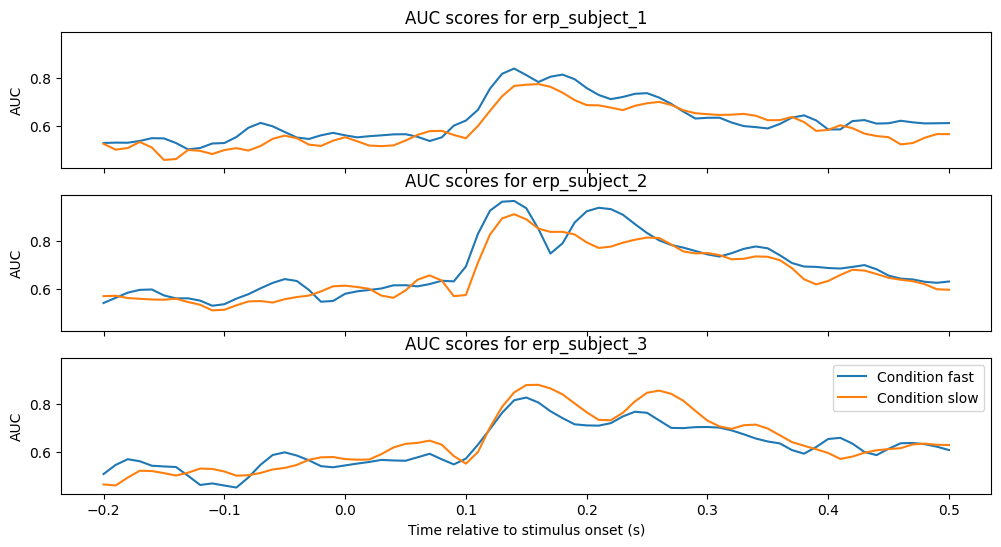

In [6]:
# Set decoding time points
tstep = 0.010
clf_times = np.arange(tmin, tmax+tstep, tstep)

# Initialize classifier
lda = ToeplitzLDA(n_channels=n_channels)

n_sessions = len(conf['auditory_oddball']['session_list'])
fig, axes = plt.subplots(n_sessions, 1, figsize=(12,6), sharex=True, sharey=True)

for s_i, session in enumerate(conf['auditory_oddball']['session_list']):
    ax = axes[s_i] if n_sessions > 1 else axes
    for c_i, condition in enumerate(conf['auditory_oddball']['condition_list']):
        
        # Compute scores with cross_val_score from sklearn
        scores = np.zeros((clf_times.shape[0],))
        for t_i, clf_time in enumerate(clf_times):
            
            # Extract the data
            epo = all_data[session][condition]
            X = epo.get_data()[:,:,epo.time_as_index(clf_time)].squeeze()
            y = epo.events[:,2]
            
            # Evaluate classifier, save average score over folds
            scores[t_i] = cross_val_score(lda, X, y, cv=5, scoring='roc_auc').mean()
            
        # Plot scores over time
        ax.plot(clf_times, scores, label=f'Condition {condition}')
        
    ax.set_title(f'AUC scores for {session}')
    ax.set_ylabel('AUC')
    
ax.set_xlabel('Time relative to stimulus onset (s)')
ax.legend()


## Step 5: Classification in the temporal domain for different channels

Now we basically do the opposite: We train one classifier per channel (thus omitting spatial information), but provide it with information from all time points of this channel. Thus our feature vector would be $N_t$-dimensional. 

As neighboring time samples probably contain very similar information, and as we want to save some computing time, we additionally use a common feature preprocessing step for ERP: we average the signal in certain time intervals, which are defined by `clf_ival_boundaries`. In this example we average, e.g., the samples between 0.1 and 0.17 seconds post stimulus before converting them into the feature vector. As a result, instead of having a 41-dimensional (every sample between 0.1 and 0.5 with a resolution of 0.01) feature vector, we only have 5 dimensions left (the five averaged time intervals). Doing this is well-justified, as our data is low-pass filtered at 16Hz, but of course you may be able to obtain better performance using other time intervals.

Again, the analysis will be repeated over the spatial dimension. Overall, this analysis allows us to see, how good classification is on each channel individually.

**Note:** as we use multiple time intervals, we 'smear' information across all time intervals. This means that the spatial information could be aligned differently in the first time interval than in the last one (i.e., a channel could be very informative in one time interval but not in the others). To see spatial classification performance in each time interval, you would need to also iterate over the intervals of `clf_ival_boundaries`.


In [7]:
def get_jumping_means(epo, boundaries):
    shape_orig = epo.get_data().shape
    X = np.zeros((shape_orig[0], shape_orig[1], len(boundaries)-1))
    for i in range(len(boundaries)-1):
        idx = epo.time_as_index((boundaries[i], boundaries[i+1]))
        idx_range = list(range(idx[0], idx[1]))
        X[:,:,i] = epo.get_data()[:,:,idx_range].mean(axis=2)
    return X

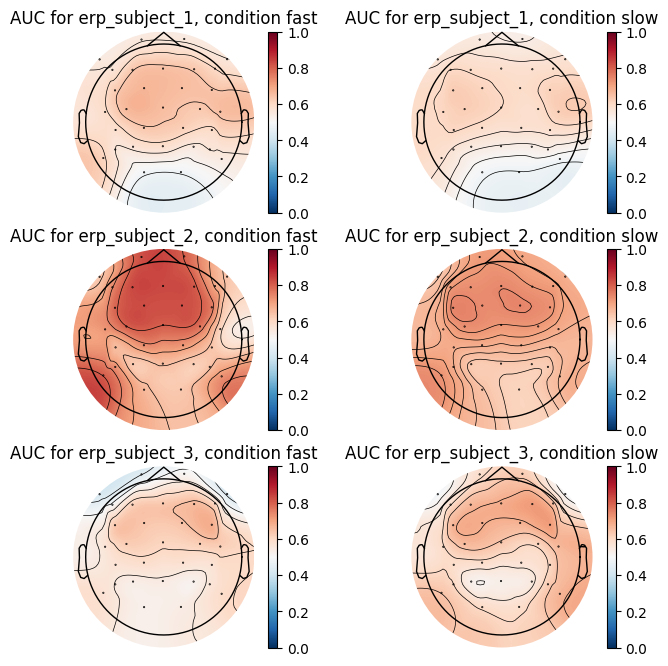

In [8]:
# The time intervals
clf_ival_boundaries = np.array([0.1, 0.17, 0.23, 0.3, 0.41, 0.5])

# Initialize classifier
lda = ToeplitzLDA(n_channels=1)

n_sessions = len(conf['auditory_oddball']['session_list'])
n_conditions = len(conf['auditory_oddball']['condition_list'])
fig, axes = plt.subplots(n_sessions, n_conditions, figsize=(8,8))

for s_i, session in enumerate(conf['auditory_oddball']['session_list']):
    for c_i, condition in enumerate(conf['auditory_oddball']['condition_list']):
        ax = axes[c_i] if n_sessions == 1 else axes[s_i, c_i]
        
        # Compute scores with cross_val_score from sklearn
        scores = np.zeros((len(epo.ch_names),))
        for ch_i, ch_name in enumerate(epo.ch_names):
            
            # Extract the data
            epo = all_data[session][condition]
            X = get_jumping_means(epo.copy().pick([ch_name]), clf_ival_boundaries).squeeze()
            y = epo.events[:,2]
            
            # Evaluate classifier, save average score over folds
            scores[ch_i] = cross_val_score(lda, X, y, cv=5, scoring='roc_auc').mean()
            
        # Plot scores over space
        im, cn = mne.viz.plot_topomap(scores, epo.info, axes=ax, cmap='RdBu_r', show=False, vlim=(0,1)) 
        ax.set_title(f'AUC for {session}, condition {condition}')
        plt.colorbar(im, ax=ax)


## Step 6: Classification in the spatio-temporal domain

The above two analysis (over space and over time) provide great inside into where the decodable information is. In practice, we usually do not split our features into spatial and temporal domains, but instead integrate information from both domains into one feature vector. This allows us to use all collected information in one go. Still, classifiers like LDA expect a feature vector, not a spatio-temporal data matrix. To arrive at one feature vector, we simply concatenate the five temporal features for every channel (note, LDA does not care about the order of the features). 


Text(0.5, 1.0, 'AUC for spatio-temporal classification')

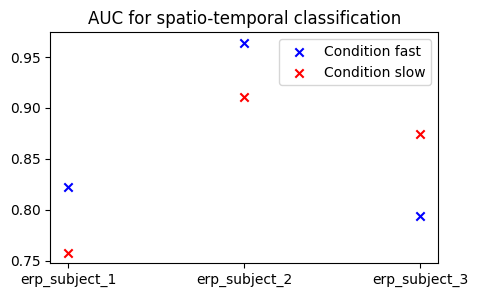

In [9]:
# The time intervals
clf_ival_boundaries = np.array([0.1, 0.17, 0.23, 0.3, 0.41, 0.5])

# Initialize classifier
lda = ToeplitzLDA(n_channels=n_channels)

n_conditions = len(conf['auditory_oddball']['condition_list'])
fig, ax = plt.subplots(1, 1, figsize=(5,3))

for s_i, session in enumerate(conf['auditory_oddball']['session_list']):
    scores = np.zeros((n_conditions,))
    for c_i, condition in enumerate(conf['auditory_oddball']['condition_list']):
        
        # Extract the data
        epo = all_data[session][condition]
        X = get_jumping_means(epo, clf_ival_boundaries).squeeze().reshape((-1, 155))  # flattens
        y = epo.events[:,2]
        
        # Evaluate classifier, save average score over folds
        scores[c_i] = cross_val_score(lda, X, y, cv=5, scoring='roc_auc').mean()
    
    # Plot scores as scatter
    ax.scatter(session, scores[0], label='Condition fast', color='b', marker='x')
    ax.scatter(session, scores[1], label='Condition slow', color='r', marker='x')
    if s_i == 0:
        plt.legend()
plt.title('AUC for spatio-temporal classification')


## Step 7: Permutation testing
You might observe that in the previous analyses, sometimes the classifier is performing around theoretical chance level (50%). Despite that (under an engineering perspective) one may conclude the classifier did a poor job, one (under a neuroscientific perspective) can be very interested in whether it is *just* above chance level, as it means that there is just some decodable information at that location (being in time or space). A common and very flexible way of significance testing in such scenario is to perform **permutation testing**. 

From Wikipedia: "A permutation test (also called a randomization test, re-randomization test, or an exact test) is a type of statistical significance test in which the distribution of the test statistic under the null hypothesis is obtained by calculating all possible values of the test statistic under all possible rearrangements of the observed data points."

To put it into context. In our dataset we are interested in whether we can decode target versus non-target from the data. For this, we got data samples that are tuples containing $(X_i, y_i)$, the data and the target label of the $i$th epoch. Now, within a permutation test, we randomize (permute) the particular structure we are originally interested in, in this case the pairing of $X_i$ with $y_i$. Concretely, here we can basically randomize this by shuffling the vector $y=[y_1, y_2, ..., y_N]$ to for instance $y_{permuted}=[y_3, y_N, ..., y_2]$. We perform the same analysis on this shuffled dataset, and save its result. If we do this many times (in the order of 1000 times), we obtain a so-called **permutation distribution** of the test statistic (e.g., classification performance). We can then look-up where in this distribution we can find our original test statistic (i.e., the one without shuffling the labels). We say that the original test statistic is significantly above chance if no more than 5% of the samples in the permutation distribution are higher than the original test statistic ($\alpha=.05$).


session erp_subject_1, condition fast: score=0.57, p=0.000
session erp_subject_1, condition slow: score=0.56, p=0.012
session erp_subject_2, condition fast: score=0.64, p=0.000
session erp_subject_2, condition slow: score=0.56, p=0.008
session erp_subject_3, condition fast: score=0.60, p=0.000
session erp_subject_3, condition slow: score=0.53, p=0.089


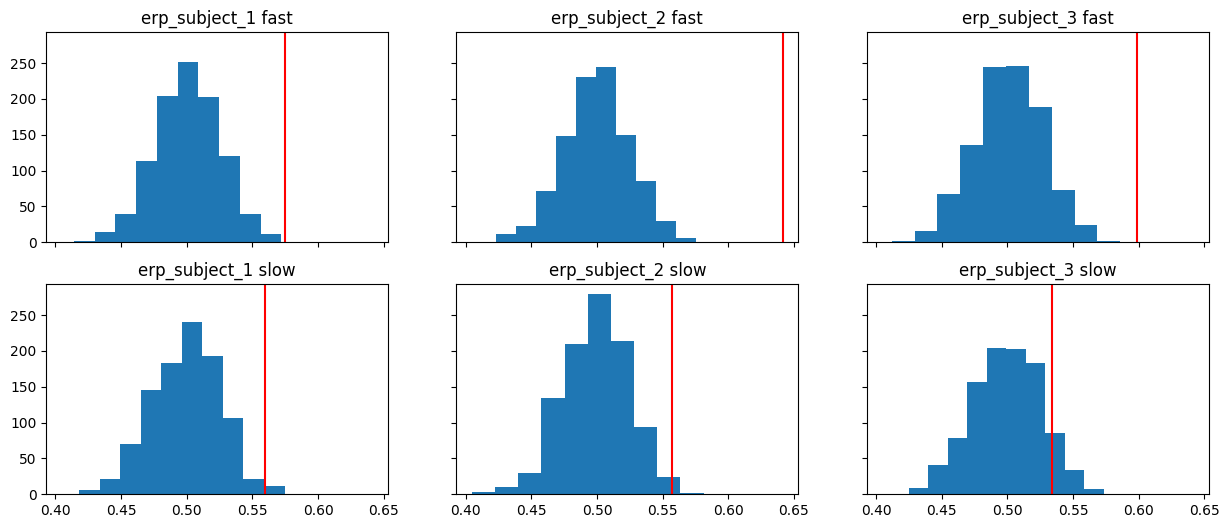

In [10]:
time = -0.05

# Note, the higher this number, the more accurate the permutation distribution, but the higher the computational load
n_permutations = 1000  

# Initialize classifier
lda = ToeplitzLDA(n_channels=n_channels)

n_sessions = len(conf['auditory_oddball']['session_list'])
n_conditions = len(conf['auditory_oddball']['condition_list'])
fig, ax = plt.subplots(n_conditions, n_sessions, figsize=(15,6), sharex=True, sharey=True)

scores = np.zeros((n_sessions, n_conditions))
permutations = np.zeros((n_sessions, n_conditions, n_permutations))
for s_i, session in enumerate(conf['auditory_oddball']['session_list']):
    for c_i, condition in enumerate(conf['auditory_oddball']['condition_list']):

        # Get the data
        epo = all_data[session][condition]
        X = epo.get_data()[:,:,epo.time_as_index(time)].squeeze()
        y = epo.events[:,2]
        
        # Estimate observed performance
        scores[s_i, c_i] = cross_val_score(lda, X, y, cv=5, scoring='roc_auc').mean()

        # Estimate permutation distribution
        for i in range(n_permutations):
            permutations[s_i, c_i, i] = cross_val_score(lda, X, np.random.permutation(y), cv=5, scoring='roc_auc').mean()
            
        # Plot the permutation distribution
        ax[c_i, s_i].hist(permutations[s_i, c_i, :])
        
        # Mark the observed accuracy
        ax[c_i, s_i].axvline(scores[s_i, c_i], color="r")
        ax[c_i, s_i].set_title(f"{session} {condition}")
        
        # Print statistics
        print("session {}, condition {}: score={:.2f}, p={:.3f}".format(
            session, condition, scores[s_i, c_i], np.mean(permutations[s_i, c_i, :]>=scores[s_i, c_i])))


# Exercises
The above cells provide a starting point for ERP preprocessing, analysis, and decoding. The following exercises allow you to play with this analysis and gain a deeper understanding.
1. The notebook uses various hyper-parameters, settings that change its overal behaviour. Such hyper-parameters could be further optimized to maximize decoding performance (potentially per participant). This can be done manually, or using a grid search. For instance:
    1. The low and high curoff of the pass-band during preprocessing
    2. The rejection criterion for outlier removal during preprocessing.
    3. The time intervals that are used to extract the the temporal features during decoding.
2. The decoding uses a cross-validation from sklearn. This cross-validation likely involves shuffling the data before folding. For temporal data, this is not ideal. Change it to a chronological cross-validation and observe the impact on performance. Similarly, observe the impact of the number of folds.
3. All decoding analyses have now been performed using all available data. A typical analysis involves the estimation of a learning curve, that is, we vary the amount of training data available to fit the decoding model. Extend the decoding to estimate such learning curves.
